## Road Segmentations in the images from Google Maps 

## [1] Load "setting.param" + * Check the sizes of the raw images in datasets
### - input : `setting.param` with the directory where the input images are located
### - output: `sm.total_df` with `./summary/(prefix+random_seed)_dataSummary.csv`

In [1]:
import modules.setting_module as set_mod
sm = set_mod.SettingModule()
checkImageSize = False
if (checkImageSize):
    sm.checkImageSize()

Setting file is loaded ... ./setting.param


Try to load the existing file: ./output/test1_32_dataSummary.csv...

===== Region [ All ] : 30 images =====
--- Train # : 21 images
--- Valid # : 3 images
---  Test # : 6 images




## [2] Load the image module and check how to resize images
### - input : `sm.total_df` 
### - output: `sm.total_df` with resize

In [2]:
import modules.image_module as img_mod
im = img_mod.ImageModule(sm)

import modules.strategy_module as strategy
sm.total_df = strategy.Resize(sm.total_df, sm.n_resize, sm.input_img_size)

## [3] Batch Grouping and Learning Step Decision: lists of batch information
### - input: `sample_df` /
### - output: `batch_train`, `batch_valid`, `n_train_steps`, `n_valid_steps`
* **Define a batch**

```
  | (nID[image], crop_x, crop_y) 1          | 
  | (nID[image], crop_x, crop_y) 2          |
  |     ......                              |
  | (nID[image], crop_x, crop_y) batch_size |
```

* **Generate `train` and `valid` batch lists respectively**

In [3]:
import modules.batch_module as bm
sample_limit = 200
bm.getBatchSize(sm.batch_size)
batch_train, batch_valid, n_train_steps, n_valid_steps = bm.groupBatch(sm.total_df, sample_limit)

Batch Size : 12
Total Training images : 21
Total Validation images : 3
Train steps: 2
Valid steps: 1


## [4] Generate batch images from the batch lists
### - input: `batch_train`, `batch_valid`
### - output: `x_batch`, `y_batch` from `trainGenerator` and `validGenerator`

In [4]:
def trainGenerator():
    while True:
        
        batch_list = batch_train
        
        for batch in batch_list:
            
            x_batch, y_batch = bm.generateBatchImages(im, batch, sm.total_df)
            
            yield x_batch, y_batch

def validGenerator():
    while True:
        
        batch_list = batch_valid
        
        for batch in batch_list:
            
            x_batch, y_batch = bm.generateBatchImages(im, batch, sm.total_df)

            yield x_batch, y_batch

## [5] Train the model

In [5]:
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import modules.evaluate_module as em

def evalTotalModel(model_name, model, window_size, doResize=True, verbose=True):
    
    start_time = time.time()
    
    prefix = em.getPrefixString(sm, model_name)
    print("Saving suffix: ", prefix)
        
    weight_file_every_epoch = './output/'+prefix+'_updateW.hdf5'
    weight_file_final ='./output/'+prefix+'_bestW.h5'
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss',
                                   factor=sm.pl_factor,
                                   patience=sm.pl_patience,
                                   verbose=1,
                                   min_delta=sm.pl_mindelta),
                 ModelCheckpoint(monitor='val_loss',
                                 filepath=weight_file_every_epoch,
                                 save_best_only=True,
                                 save_weights_only=True),
                 EarlyStopping(monitor='val_loss', 
                               patience=sm.es_patience,
                               min_delta=sm.es_mindelta)]

    model.fit_generator(generator=trainGenerator(),
                        steps_per_epoch=n_train_steps,
                        epochs=sm.epoch,
                        verbose=2,
                        callbacks=callbacks,
                        validation_data=validGenerator(),
                        validation_steps=n_valid_steps)

    model.save(weight_file_final)

    ## Check elapsed time
    end_time = time.time()
    im.training_time = end_time - start_time
    print("Elapsed Time: ", im.training_time, "[sec]")
    
    ## Make log file
    stat_df = em.saveTestStatistics(im, prefix, model, window_size, doResize, verbose)
    
    ## Plot histograms
    em.plotHistogram(stat_df, prefix)

Using TensorFlow backend.


Saving suffix:  test1_32_unet
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
2/2 - 12s - loss: 1.8165 - dice_coeff: 0.0167 - val_loss: 1.6901 - val_dice_coeff: 1.0203e-05 - lr: 1.0000e-04
Epoch 2/2
2/2 - 12s - loss: 1.7236 - dice_coeff: 0.0161 - val_loss: 1.6872 - val_dice_coeff: 1.0234e-05 - lr: 1.0000e-04
Elapsed Time:  58.97273230552673 [sec]
Save a logfile:  ./output/test1_32_unet_testStats.txt
Predict: ME_0001  / elapsed time:  0.8 [sec]
Predict: ME_0030  / elapsed time:  0.3 [sec]
Predict: ME_0050  / elapsed time:  0.3 [sec]
Predict: ME_0015  / elapsed time:  0.3 [sec]
Predict: ME_0048  / elapsed time:  0.3 [sec]
Predict: ME_0002  / elapsed time:  0.3 [sec]
Save a dataframe:  ./output/test1_32_unet_testStats.csv


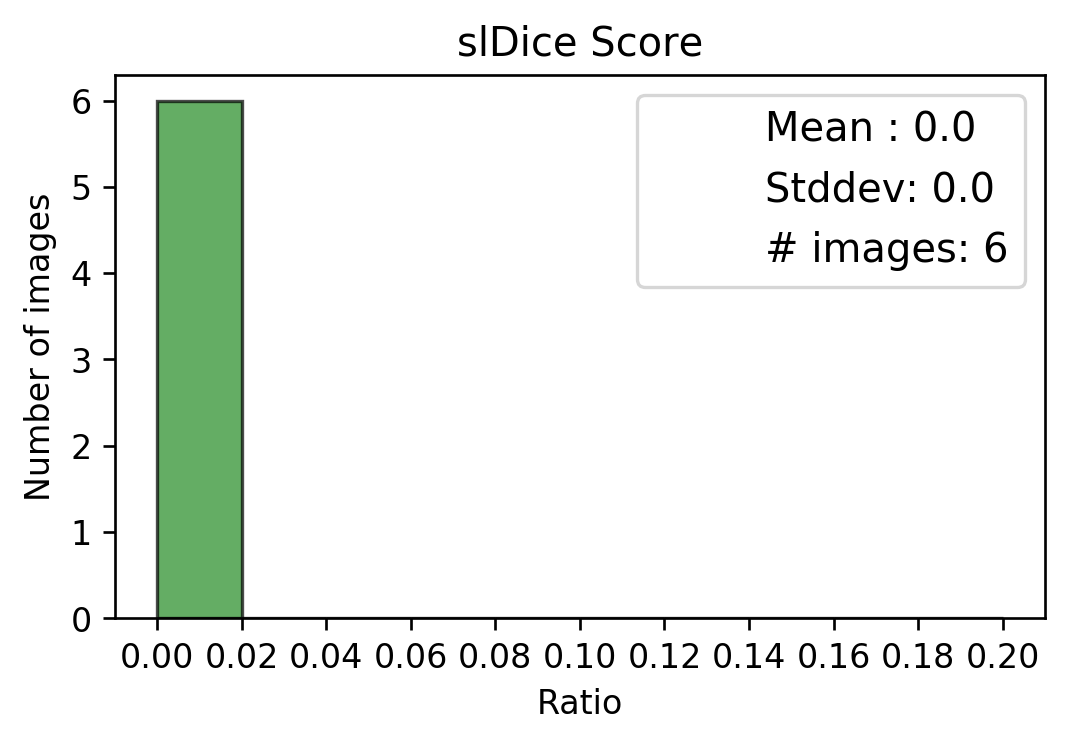

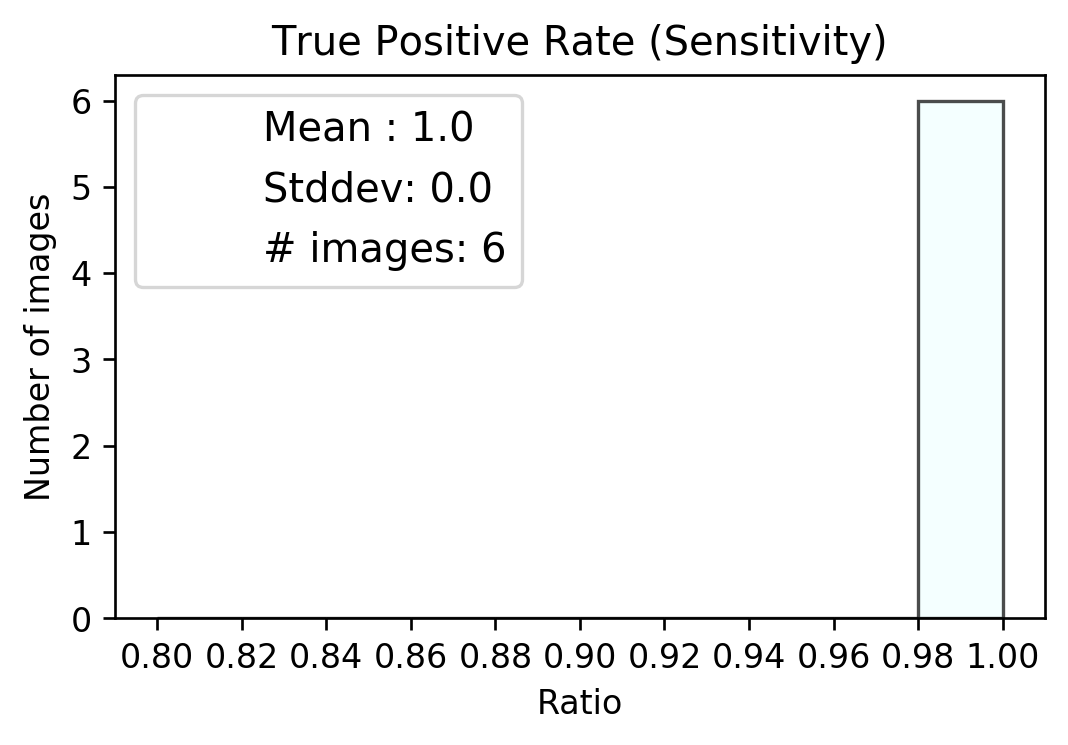

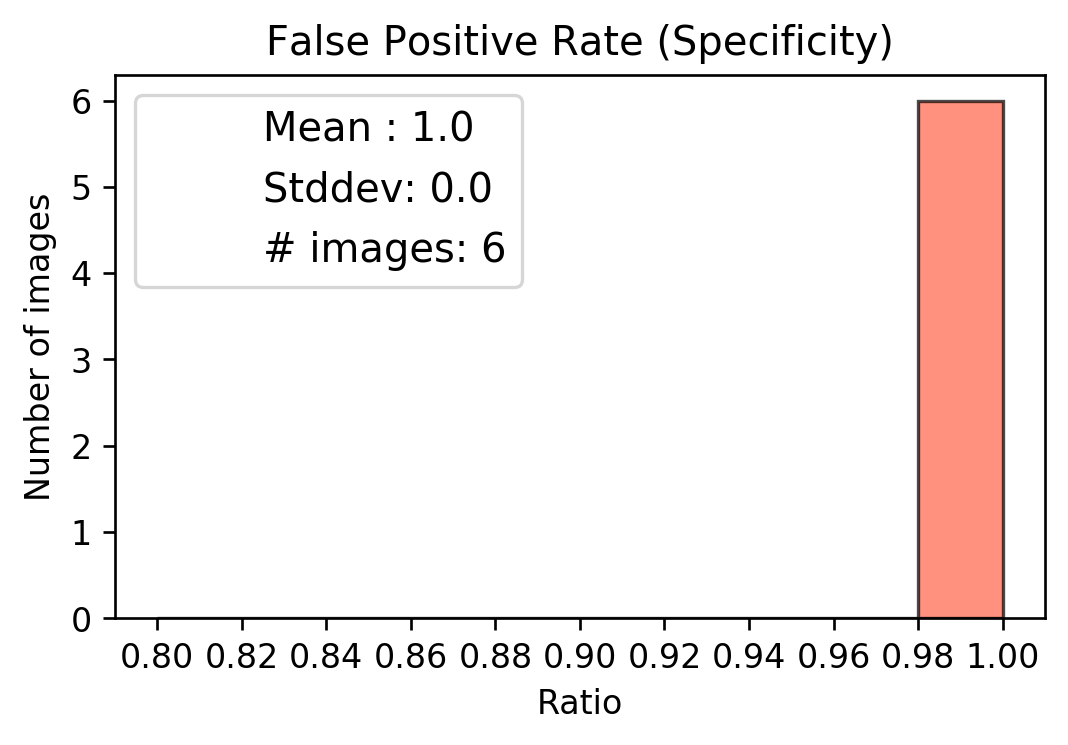

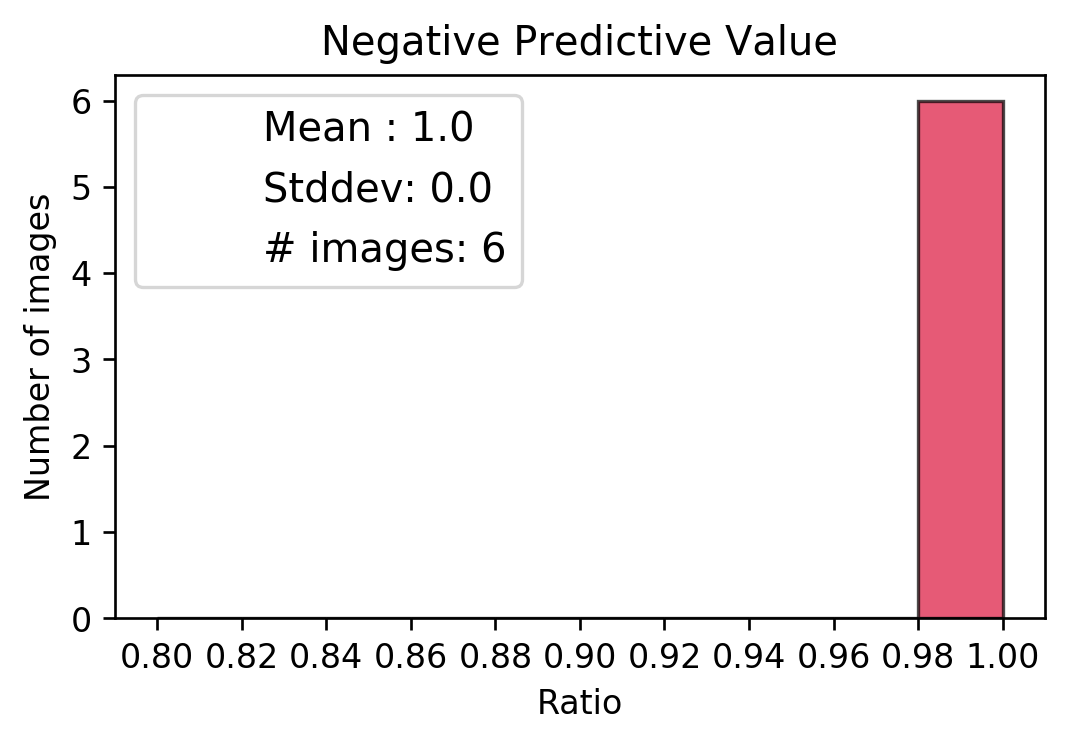

In [6]:
doResize=True
verbose=True
window_size = im.input_img_size
im.pre_process=False  # Set to False just to check it works

## Pure U-Net
from model.u_net import get_unet_256
model_unet = get_unet_256()
evalTotalModel("unet", model_unet, window_size, doResize, verbose)

# GL-Dense-U-Net
# from model.gl_dense_u_net import get_gl_dense_unet
# model_gl = get_gl_dense_unet()
# evalTotalModel("gl", model_gl, window_size, doResize, verbose)

## Load Models

In [7]:
# from model.u_net import get_unet_256

# model_unet = get_unet_256()
# model_unet.load_weights('./output/state13_92_unet_bestW.h5')
# prefix = 'mixed'

In [8]:
# import modules.evaluate_module as em
# stat_df = em.saveTestStatistics(im, prefix, model_unet, im.input_img_size, True, True)

## Scratch Notes

In [9]:
# import matplotlib.pyplot as plt

# nID = 13

# img1 =im.loadSingleIMG(nID)
# mask1 = im.loadSingleGT(nID)
# img2, mask2 = im.loadImageSet(nID)


# plt.imshow(img2)